<a href="https://colab.research.google.com/github/Ujustwaite/ml1/blob/master/Playing_With_Fire.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [242]:
! pip install pandas
! pip install sodapy
! pip install geopy
! pip install numpy
! pip install seaborn
! pip install matplotlib
! apt install proj-bin libproj-dev libgeos-dev
! apt-get install libgeos-3.5.0
! apt-get install libgeos-dev
! pip install https://github.com/matplotlib/basemap/archive/master.zip
! pip install pyproj==1.9.6
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip


Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
libproj-dev is already the newest version (4.9.3-2).
proj-bin is already the newest version (4.9.3-2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
E: Unable to locate package libgeos-3.5.0
E: Couldn't find any package by glob 'libgeos-3.5.0'
E: Couldn't find any package by regex 'libgeos-3.5.0'
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libgeos-dev is already the newest version (3.6.2-1build2).
0 upgraded, 0 newly installed, 0 to remove and 8 not upgraded.
     \ 190.8MB 1.0MB/s
  Created wheel for basemap: filename=basemap-1.2.1-cp36-cp36m-linux_x86_64.whl size=121756015 sha256=04e654f622c75a41d43eec73a7602ab619207136f300e6f60a7baed795208165
  Stored in directory: /tm

# Laboratory 1: Examining New York City (NYC) Fire Incidents

### Team Members: Chase Henderson, Aditya Garapati, Carl Walenciak, Brian Waite


## Business Understanding

### Data General Description: 

The Fire Department of New York City (FDNY) collects data on all incidents handled by non-EMS units including fire, medical and non-fire emergencies. This data is more broadly collected in support of the New York Fire Incident Reporting System (NYFIRS) and the National Fire Incident Reporting System (NFIRS). According to the New York City Open Data platform (https://data.cityofnewyork.us) NFIRS data was originally intended to aid in understanding the nature and causes of fire, civilian fire casualties and firefighter injuries, but has since expanded to collect information on all incidents to which fire units respond. [1]

Although FDNY Incident data is available from 2013 through June, 2018, the total number of records for that period is approximately 2.5 Million and represented a challenge to computing resources available to the team. In order to limit the size of the data set, but still achieve the research objectives, the team downselected the data set to include only fire incident records from the one year period beginning 07-01-2017 at 12AM through 06-30-2018 at midnight. The resultant set contains 337,210 records with 25 original feature columns.

### Data Determined Out of Scope: 

As indicated above, the original FDNY Incident data set contains a variety of incident types including non-fire medical emergencies, gas leaks, support to police activity and wide variety of other events. In order to deliver meaningful analytic outcomes and focus on specific challenge problems, we down scoped our data set to include only fire-related incidents (indicated within the data set as 100-series (1XX) incidents. This reduces the final data set of interesting events to 26,339 events that are just fires. 

### Supplemental Data: 

In order to enable the team to ask more robust questions of interest of the primary data, we sought additional associated or relevant data to supplement our analysis. This includes: 

* Firebox Location Data: Each incident within the primary data set is linked to a specific firebox. New York City's unique infrastructure includes a series of over 15,000 on-street fireboxes that allow easy access to emergency services. While many of these are in varying states of repair, the FDNY uses them as geographic reference points for the dispatch of units and the records kept in the primary dataset. The team sought and identified geo-reference data to improve the utility of the firebox field in the primary data set. This was obtained from reference [2]. Although this data is somewhat dated -- last updated in 2008 -- the age of the NYC Firebox system and the immobility of the devices makes us confident that the location information is unchanged. Data for 16,284 fireboxes is listed. 

* Firehouse Location Data: The team also sought and identified a complete listing of the name, type, and geo-reference data of all 213 firehouses in the boroughs of NYC. [3]

* Precipitation Data: Thinking that road conditions, particularly associated with heavy rainfall or snow accumulation could impact response times, we sought and obtained weather data for New York City's Central Park for the entire period of the data set. These values are "daily" and are linked in the final data set with the date of the incident. 

### Analytic Questions of Interest: 

Using this publicly available data set, the team has identified a number of potential analytic questions of interest that could potentially provide value to FDNY and NYC decision makers regarding the allocation of financial and personnel resources. Specific questions of interest could include: 

* Identification of regions of New York City where fire incidents are most likely to occur. 
* Prediction of the response time and/or total incident duration based on available features. 
* Identify trends within the data set that might indicate increased periods of risk. 

These insights could specifically be used to determine which fire stations should receive additional personnel or equipment resources or design staffing schedules to coincide with the most likely periods of fire related activity. 

Further, this analysis may help to aid in the identification of problem neighborhoods where increased inspection activity or public education campaigns could help to contribute to additional fire prevention measures being deployed in a proactive fashion by city decision makers. 

### Measuring Outcomes from the Data: 

The team believes that this data set can support a variety of analytic methodologies and provide interesting answers to the question of interest above. Techniques available will include both classification and regression based models. In order to ensure validity of results, all evaluations of data will be on a 70/30 train/test split of the data with test data being withheld for final testing and not made available for model improvement at any stage of the analysis. 

Below we describe our evaluative criteria for each type of model anticipated: 

In all cases, our models will be evaluated on whether the findings are logical and representative of reasonable outcomes given the data provided and are consistent with the exploratory data analysis. 

*Linear Regression:* 

Feature selection for inclusion in the model will likely make use of feature down-selection techniques including forward, backward, LASSO or ELASTIC-NET selection techniques with Bayesian Information Criteria, Adjusted R-Squared, and Residual Sum of Squares acting as the primary selection criteria. These criteria will also be used to evaluate the model fit in comparison to the test data set. 

*Classification:*

Evaluation of classification models will be through the use of confusion matrix based statistics including accuracy, sensitivity and specificity. In addition, the Area Under the Curve (AUC) assessments using Receiver Operating Characteristic (ROC) curve analysis will be used to compare model performance and to evaluate the performance of any final selected model. 

In [0]:
# Imports section
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from geopy import distance
from sodapy import Socrata
from mpl_toolkits.basemap import Basemap
import missingno as msno
import requests
from google.colab import drive
import datetime as dt
import pandas_profiling
from IPython.display import display, HTML

In [244]:
# Data Import From City of New York
# Ignore warning regarding API limitations as that is only regarding programming requests at speed. 

# Unauthenticated client only works with public data sets. Note 'None'
# in place of application token, and no username or password:
client = Socrata("data.cityofnewyork.us", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(data.cityofnewyork.us,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("tm6d-hbzd", limit = 500000)#limit=300000000)

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

#Get the firehouse location information
firehouse_info = client.get("hc8x-tcnd", limit=10000)

firehouse_df = pd.DataFrame.from_records(firehouse_info)
firehouse_df = firehouse_df.dropna()

#Set up Google Drive access to additional data stored there
drive.mount('/content/drive')

#Get the firebox location information
firebox_locs = pd.read_csv("/content/drive/My Drive/Fire Data/Fire Boxes.csv", names=['LONG','LAT','fire_box','nearest_intersection'])



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
#Get the precipitation information for NYC on the dates of interest
precip = pd.read_csv("/content/drive/My Drive/Fire Data/Rain_Snow.csv")
precip['DATE'] = pd.to_datetime(precip['DATE'])

In [0]:
#convert dates to date time objects
results_df['arrival_date_time']=pd.to_datetime(results_df['arrival_date_time'])
results_df['incident_date_time']=pd.to_datetime(results_df['incident_date_time'])
results_df['last_unit_cleared_date_time']=pd.to_datetime(results_df['last_unit_cleared_date_time'])

In [0]:
#Limit results to the most recent 1 year time frame available -- July 2017 through June 2018
results_df = results_df[results_df['incident_date_time'] > pd.to_datetime('2017-07-01 00:00:00')]

#Calculate new feature "response_time" that is the arrival time of units on scene minus the time the incident occured. 
#Convert to a numeric type and convert units to minutes. 
results_df['response_time'] = (results_df['arrival_date_time'] - results_df['incident_date_time'])
results_df['response_time'] = pd.to_numeric(results_df['response_time'])
results_df['response_time'] = results_df['response_time']/ 60000000000

#Convert other data elements to the proper type
results_df['units_onscene'] = pd.to_numeric(results_df['units_onscene'])
results_df['total_incident_duration'] = pd.to_numeric(results_df['total_incident_duration'])
results_df['story_fire_origin_count'] = pd.to_numeric(results_df['story_fire_origin_count'])
results_df['fire_box'] = results_df['fire_box'].astype('str')

#Convert firehouse values
firehouse_df['latitude'] = pd.to_numeric(firehouse_df['latitude'])
firehouse_df['longitude'] = pd.to_numeric(firehouse_df['longitude'])


In [0]:
#Add the borough code to the firebox column to enable merging with the firebox location data set
results_df.loc[results_df['borough_desc'].str.match('1 - Manhattan'), 'fire_box'] = 'M' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('2 - Bronx'), 'fire_box'] = 'X' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('3 - Staten Island'), 'fire_box'] = 'R' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('4 - Brooklyn'), 'fire_box'] = 'B' + results_df.fire_box
results_df.loc[results_df['borough_desc'].str.match('5 - Queens'), 'fire_box'] = 'Q' + results_df.fire_box

In [0]:
#Merge the fire_box dataframe with the overall dataframe
final_df = pd.merge(results_df, firebox_locs, on = 'fire_box')
final_df['LAT'] = pd.to_numeric(final_df['LAT'])
final_df['LONG'] = pd.to_numeric(final_df['LONG'])

In [0]:
#Reduce only to fire types
final_df[['incident_code','incident_desc']]=final_df.incident_type_desc.str.split('-', expand=True, n=1)
final_df.incident_code.str.strip()
final_df.incident_desc.str.strip()
final_df['incident_code'] = pd.to_numeric(final_df['incident_code'],errors='coerce')
final_df = final_df[final_df.incident_code < 200]

In [0]:
def findNearestFirestation (Lat, Long):
    minDistance = 1000
    for fireLat, fireLong in zip(firehouse_df.latitude, firehouse_df.longitude):
        distanceFire = distance.distance((Lat, Long), (fireLat,fireLong)).miles
        if distanceFire < minDistance: 
            minDistance = distanceFire
    return minDistance

# #Uncomment to run this code, but takes multiple hours to calculate distance for each point. 
# #Get the nearest fire station
# #This code takes a long time to run because it needs to calculate the distance for each firebox to all fire stations and then select the minimum.
# final_df['Distance_To_Nearest_Station'] = 0
# i = 0
# for lat, long in zip (final_df.LAT, final_df.LONG): 
#     dist = findNearestFirestation(lat,long)
#     final_df['Distance_To_Nearest_Station'].iloc[i] = dist
#     i = i + 1

In [0]:
#Save the final file to a pickle file so that we don't have to re-run
#Uncommenting will overwrite the existing data file and will take time to generate if not running the distance to fire station code above. 
#final_df.to_pickle('/content/drive/My Drive/Fire Data/fireData_July17.pkl')

In [253]:
final_df.head()

action_taken1_desc  ...                                   incident_desc
7   86 - Investigate                               ...   Cooking fire, confined to container          
9   11 - Extinguishment by fire service personnel  ...   Cooking fire, confined to container          
13  21 - Search                                    ...   Fuel burner/boiler malfunction, fire confined
28  11 - Extinguishment by fire service personnel  ...   Fire, other                                  
30  11 - Extinguishment by fire service personnel  ...   Cooking fire, confined to container          

[5 rows x 30 columns]

In [0]:
#All code above this line is to create the initial data set. Due to size and the time required to generate the "Distance_To_Nearest_Station" feature, we have run and stored the data file 
#of line in a "pickle" file to enable rapid analysis by the team. This file is read in here and retains all of the data type associations generated above. 

final_df = pd.read_pickle('/content/drive/My Drive/Fire Data/fireData_July17.pkl')

In [0]:
#Drop the unnecessary precip data
precip.drop(['STATION', 'NAME', 'LATITUDE', 'LONGITUDE', 'ELEVATION'], axis=1, inplace=True)

#Pull out the date to support merge
final_df['DATE'] = final_df.apply (lambda row: row['incident_date_time'].date(), axis=1)

#Some magical required type conversion
final_df['DATE'] = pd.to_datetime(final_df['DATE'])
precip['DATE'] = pd.to_datetime(precip['DATE'])

#Merge the precipitation data with the final data frame
final_df = pd.merge(final_df, precip, on = 'DATE')


## Data Meaning and Type Description 

The below variable listing describes the name, description, type, and unit values for each of the variables retained in the dataframe to be used to support this analysis. 

In [0]:
#Put together a dataframe to store the variable descriptions for ease of use. 

#Get the variable names from the column header
variables = final_df.columns

In [0]:
#Convert to a dataframe
variable_df = pd.DataFrame(variables)

In [0]:
#Build additional columns in the dataframe with the description, type, and units. 

variable_df['Description'] = ['The code and description of the first action taken by units on the scene.',
                              'The code and description of the second action taken by units on the scene.',
                              'The code and description of the third action taken by units on the scene.',
                              'Indicator for whether an Automatic Extinguishing System (AES) is present.',
                              'Arrival Date and Time of the first unit on the scene.',
                              'The borough in which the incident occured. One of: Bronx, Brooklyn, Manhattan, Queens, Staten Island.',
                              'Indicator for whether a Carbon Monoxide Detector was present.',
                              'Indicator for whether a Smoke Detector was present.',
                              'The emergency firebox where the incident occured and to which units responded. Character represents the borough and numeric value is unique ID.',
                              'Indicator for whether the fire began below grade or not.',
                              'Description of how far the fire spread from the object of origin.',
                              'The floor of the building on which the incident occured.',
                              'Highest level of alarm the incident achieves. Evaluated after completion.',
                              'Unique incident key value to identify the incident. Not used for analysis beyond identification of records.',
                              'Date and Time on which incident occured. Assumed to be reported in local time.',
                              'Incident type code (100-series for fire) and specific description of type of fire.',
                              'Date and time the last responding unit left the scene of the incident.',
                              'The code and description of the type of street or building where the incident took place',
                              'Indicator of whether a standpipe (hydrant) was in the vicinity of where the fire began.',
                              'Story on which the fire originated.',
                              'Name of the street where the incident took place.',
                              'The total number of seconds from whe then incident was created to when the incident was closed.',
                              'Total number of units that arrived on scene.',
                              'Zip code where the incident occured.',
                              'An engineered feature derived from arrival time of first units on scene and the time the incident occured.',
                              'Longitude of the location where the incident occured.',
                              'Latitude of the location where the incident occured.',
                              'Nearest intersection to the firebox where the incident was reported.',
                              'Unique incident type code parsed from incident code and description above.',
                              'Incident description parsed from incident code and description above.',
                              'An engineered feature derived by measuring the distance between the nearest firehouse location and the firebox. Straight line distance using Mercator projection.',
                              'Month, Day, and Year of incident.',
                              'Precipitation amount as measured in Central Park on date of the incident.',
                              'Amount of precipitation that was recorded as snowfall.',
                              'Amount of snow accumulation reported on the day of the incident.']
variable_df['Type'] = ['Categorical',
                       'Categorical',
                       'Categorical',
                       'Categorical',
                       'Datetime',
                       'Categorical',
                       'Categorical',
                       'Categorical',
                       'Categorical',
                       'Categorical',
                       'Categorical',
                       'Categorical',
                       'Categorical',
                       'String',
                       'Datetime',
                       'Categorical',
                       'Datetime',
                       'Categorical',
                       'Categorical',
                       'String',
                       'Numeric',
                       'Numeric',
                       'Numeric',
                       'Categorical',
                       'Numeric',
                       'Numeric',
                       'Numeric',
                       'String',
                       'Categorical',
                       'String',
                       'Numeric',
                       'Datetime',
                       'Numeric',
                       'Numeric',
                       'Numeric'
                                            
                       ]

variable_df['Units'] = ['N/A',
                        'N/A',
                        'N/A',
                        'N/A',
                        'N/A',
                        'N/A',
                        'N/A',
                       'N/A',
                       'N/A',
                        'N/A',
                        'N/A',
                       'N/A',
                       'N/A',
                       'N/A',
                       'N/A',
                       'N/A',
                       'N/A',
                       'N/A',
                        'N/A',
                        'Floors',
                       'N/A',
                       'Seconds',
                       'Number of Fire Response Units',
                       'N/A',
                       'Minutes',
                       'Degrees Longitude',
                       'Degrees Latitude',
                       'N/A',
                       'N/A',
                       'N/A',
                       'Miles',
                       'N/A',
                       'Inches',
                       'Inches',
                       'Inches',
                                     
                       ]
variable_df.rename(columns={0:'Feature'},inplace=True)


In [259]:
#Display and ensure that the full description is shown. 
pd.set_option('display.max_colwidth', -1)
display(HTML(variable_df.to_html()))

## Profile Report on the New York City fire dataset. 



The below report provides an opportunity to interact directly with the datatypes and identify attributes, ranges, summary statistics, correlation and missing values of features in the dataset. Specific areas of interest identified by the team in this reporting or other exploratory data analysis are called out below this report and addressed as needed. As an additional supplement to this and the above definitions, a reference to NYC Fire Dispatch codes is available at: http://www.fdnewyork.com/aa.asp. 

In [260]:

#generate the report
profile = final_df.profile_report(style={'full_width':True}, correlations={"cramers": False})
profile

## Data Quality: Addressing Missing Values, Outliers, Duplicates and Other Issues Identified

### Missing value analysis: 

Looking at the above profile report and on subsequent review of the data, we could easily identify large portions of the data that are missing or are appropriately not reported. A matrix plot helps us to visualize where the large portions of missing data are held. 





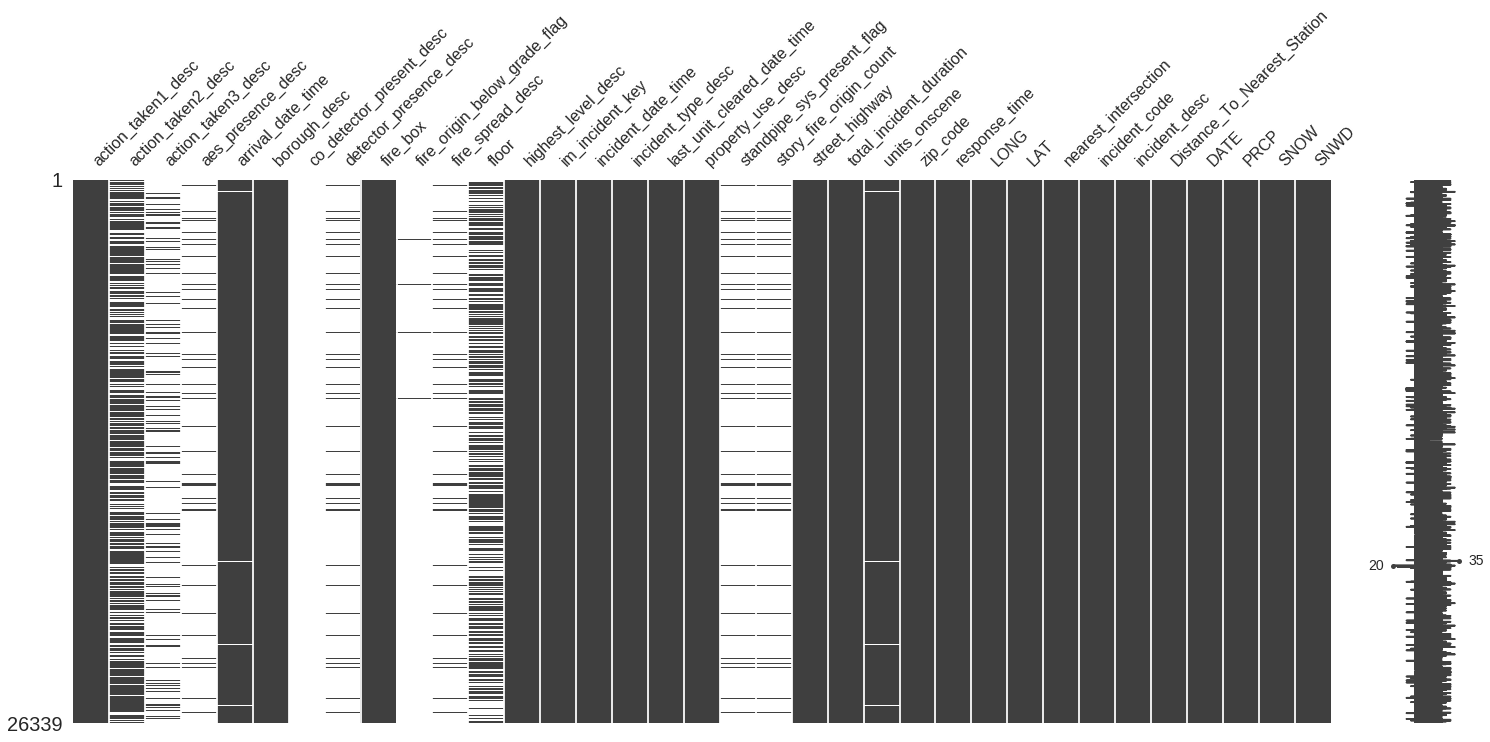

In [261]:
#Display the missing value matrix plot
msno.matrix(final_df)

### Unlikely to be able to impute. 

As we can see from the plot above, a number of the columns have significant missing values (indicated by whitespace). Many of these values are likely due to under-reporting by the participating fire units in the incident response after the fact or due to non-applicability of the field to the specific incident type reported. 

Example columns with significant missing values include `co_detector_presence_desc` and `detector_presence_desc` which indicate whether a carbon-monoxide or regular smoke detector were reported present at the scene. While this could potentially impact the rate at which a fire spreads or the scale of the fire prior to being reported, we do not believe we have enough of these values to make valid inferences and that they do not more broadly impact our questions of interest.

### Imputation Possible. 

For some other variables, we do believe that imputation of the missing values or values that were engineered but are inaccurate due to other missing values. One example is the `response_time` variable we created above. Because there are missing values for some of the arrival times, the response time variable is negative, which we know cannot be possible. In the following code, we seek to impute these values while adjusting for the borough in which the incident occurs to retain some fidelity of the data. 

Additionally, the `units_onscene` variable has relatively few missing values. We felt that we could confidently impute these values according to borough, response time, and the incident type, thinking that similar units would be called to respond to similar incidents. This code is also below. 

#### Imputation of Response Time: 

In [0]:
# Create Response Time Cross Reference
filter_to = final_df['response_time'] > 0
xref_resp_time = final_df[filter_to][['borough_desc', 'response_time']]
xref_resp_time = xref_resp_time.rename(columns = {"response_time":"resp_time_mean"})
xref_resp_time = pd.DataFrame(xref_resp_time.groupby('borough_desc').mean())

In [0]:
# Merge Data with Mean XRef
final_df = final_df.merge(xref_resp_time, how = 'left', on = 'borough_desc', indicator = True)

In [0]:
# Set On Scene to XXXXX where Null
filter_to = final_df['response_time'] <= 0
final_df.loc[filter_to, 'response_time'] = final_df[filter_to]['resp_time_mean']

In [0]:
final_df = final_df.drop(['resp_time_mean', '_merge'], axis = 1)

#### Imputation of Units Onscene

In [0]:
# Create Units Onscene Cross Reference
filter_to = final_df['units_onscene'].isnull()== False
xref_units_onscene = final_df[filter_to][['borough_desc','incident_type_desc', 'units_onscene']]
xref_units_onscene = xref_units_onscene.rename(columns = {"units_onscene":"onscene_mean"})
xref_units_onscene = pd.DataFrame(xref_units_onscene.groupby('incident_type_desc').mean())

In [0]:
# Merge Data with Mean XRef
final_df = final_df.merge(xref_units_onscene, how = 'left', on = 'incident_type_desc', indicator = True)

In [0]:
# Set On Scene to XXXXX where Null
filter_to = final_df['units_onscene'].isnull()
final_df.loc[filter_to, 'units_onscene'] = final_df[filter_to]['onscene_mean']

In [0]:
final_df = final_df.drop(['onscene_mean', '_merge'], axis = 1)

In [0]:
#Set up to downsample by borough, by month. 
final_df['incident_month'] = final_df['incident_date_time'].dt.month
boroughs = final_df['borough_desc'].unique()
months = final_df['incident_month'].unique()

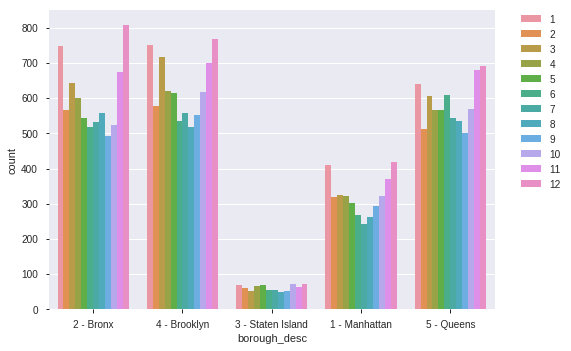

In [271]:
#Event count distribution prior to sampling
sns.countplot(x="borough_desc", hue='incident_month', data=final_df)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [0]:
# Down sampling code no longer required. 

# sample_size = 50000
# sampled_df = pd.DataFrame()

# for i in boroughs:
#     #Filter to Borough
#     temp_df = final_df[final_df['borough_desc'] == i]
    
#     for x in months:
#         #Filter to Month
#         temp_df2 = temp_df[temp_df['incident_month'] == x]
        
#         #Get Proportional Sample Size
#         num_of_samples = sample_size * (temp_df2.shape[0]/final_df.shape[0])
        
#         #Sample Data
#         temp_sampled = temp_df2.sample(n = round(num_of_samples), random_state = 123)
        
#         #Assign to Dataframe
#         sampled_df = pd.concat([sampled_df, temp_sampled])
        
# #store the sampled dataframe back as final_df
# final_df = sampled_df

In [0]:
# #Event count distribution after sampling
# sns.countplot(x="borough_desc", hue='incident_month', data=final_df)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

Still to address: 
* Describe the missing data identified by looking at the map. 


In [0]:


#Drop the cells with missing values that we are choosing not to impute
drop_cols =[  'aes_presence_desc'
            , 'action_taken2_desc'
            , 'action_taken3_desc'
#            , 'arrival_date_time' #Choosing not to drop after team discussion. 
            , 'co_detector_present_desc'
            , 'detector_presence_desc'
            , 'fire_origin_below_grade_flag'
            , 'fire_spread_desc'
            , 'standpipe_sys_present_flag'
            , 'story_fire_origin_count'
           ]

final_df = final_df.drop(drop_cols, axis = 1)

## Missing Values After Imputation and Drops

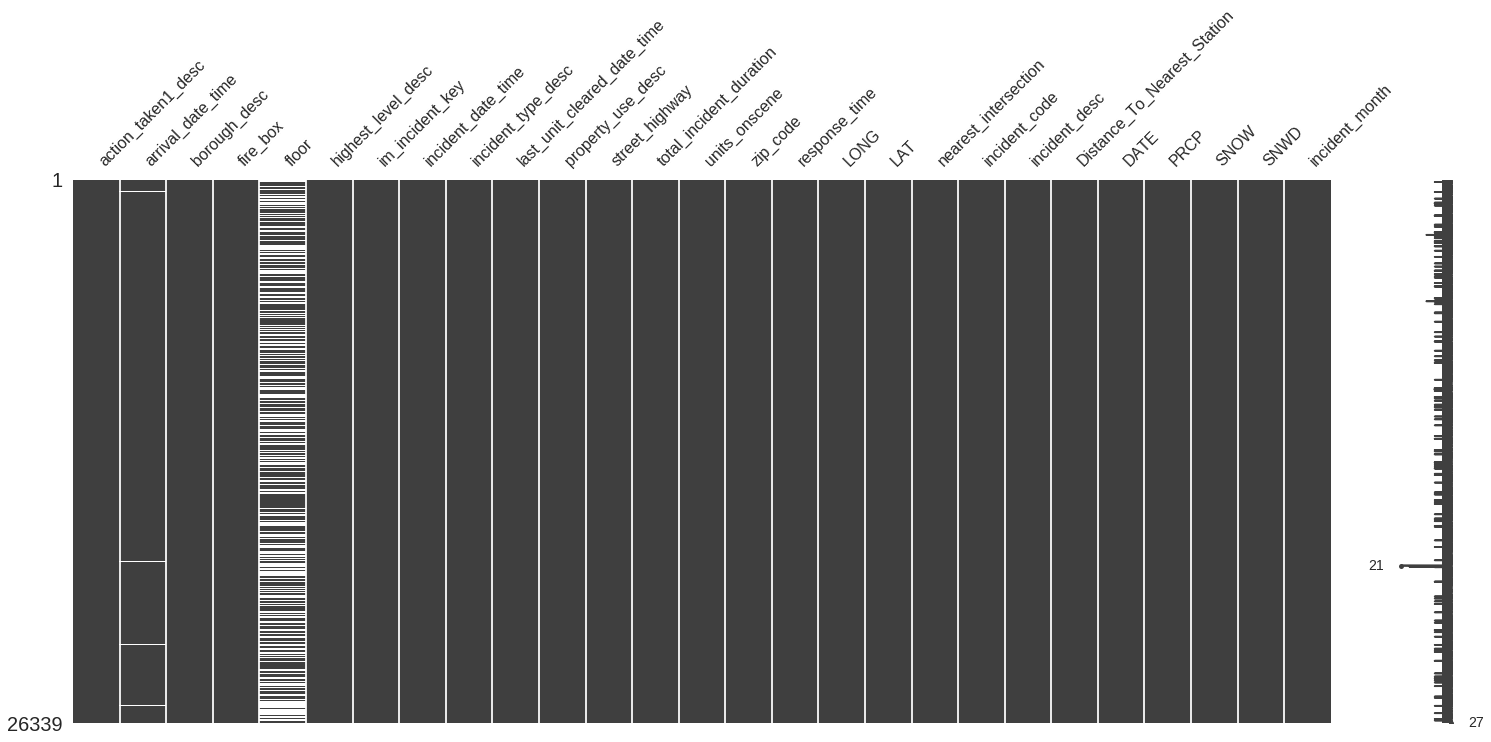

In [275]:
msno.matrix(final_df)

## Additional Exploratory Analysis

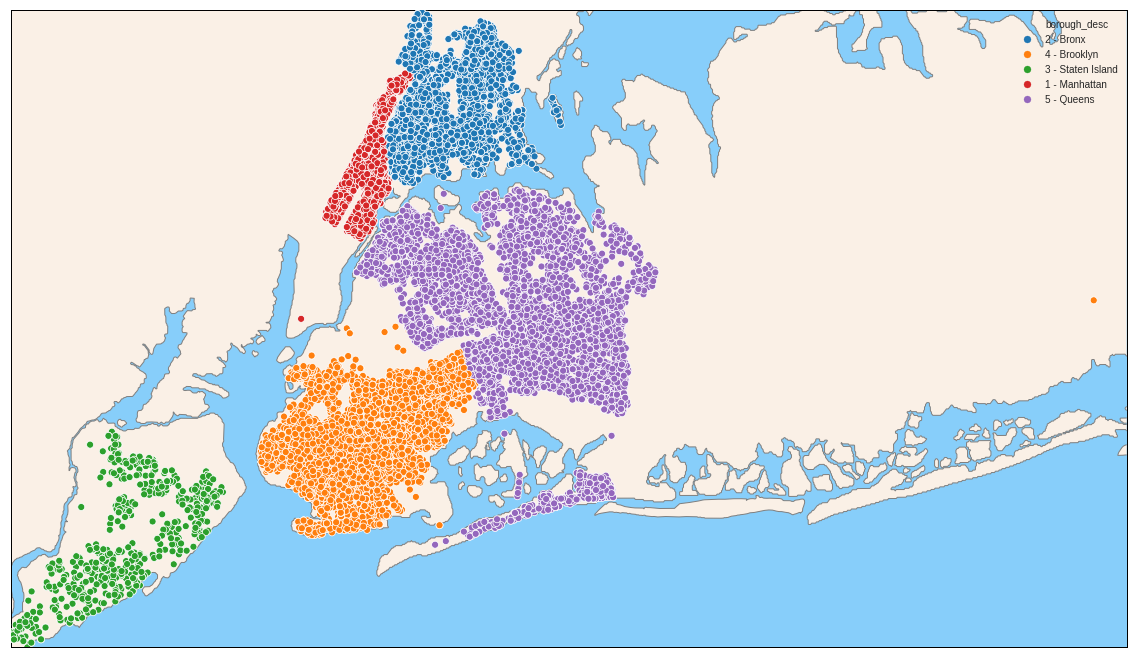

In [276]:
#Generate a plot of the incidents in the data set by borough
fig = plt.figure(figsize=(20, 20))
m = Basemap(projection='tmerc',area_thresh = 0.1, resolution='f', llcrnrlon = final_df.LONG.min(), llcrnrlat = final_df.LAT.min(),
urcrnrlon = final_df.LONG.max()+.03, urcrnrlat = final_df.LAT.max(), lat_0 = final_df.LAT.mean(), lon_0 = final_df.LONG.mean())
m.drawmapboundary(fill_color='lightskyblue')
m.fillcontinents(color='linen',lake_color='lightskyblue')
m.drawcoastlines(color='gray')
m.drawrivers(color='lightskyblue')
#Fill the globe with a blue color 

#Fill the continents with the land color

#Include this for the building footprint map
#m.readshapefile(shpfile, 'metro', linewidth=.15)
x, y = m(final_df.LONG.tolist(), final_df.LAT.tolist())
sns.scatterplot(x,y, hue = final_df.borough_desc, zorder = 15)

plt.show()

In [0]:
##Begin Aditya's Code

def groupByBurough_dwelling (df):
   grouped = df.groupby('borough_desc')
   for name,group in df.groupby('borough_desc'):
               plt.figure(name)
               sns.countplot(y="property_use_desc",data=group,order=group.property_use_desc.value_counts().iloc[:5].index).set_title(name)
   return

from datetime import datetime

def groupByBurough_callTime (df):
   for name,group in df.groupby('borough_desc'):
       print(name)
       df2=group.set_index('arrival_date_time')
       ts_df=df2.loc[df2.index.notnull()]
       ts_df.index = pd.to_datetime(ts_df.index)
       ts_df['hour_of_call'] = ts_df.index.hour
       plt.figure(name)
       sns.countplot(x="hour_of_call",data=ts_df).set_title(name)
   return

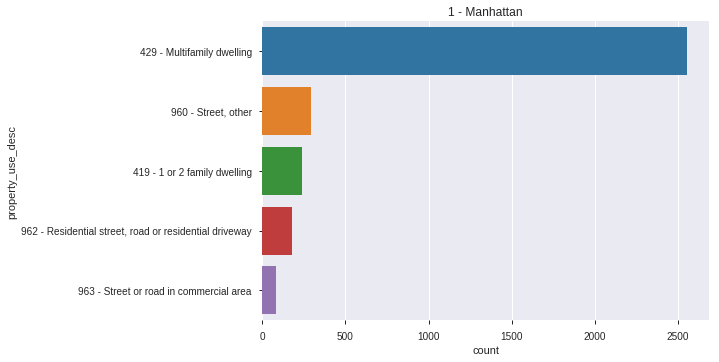

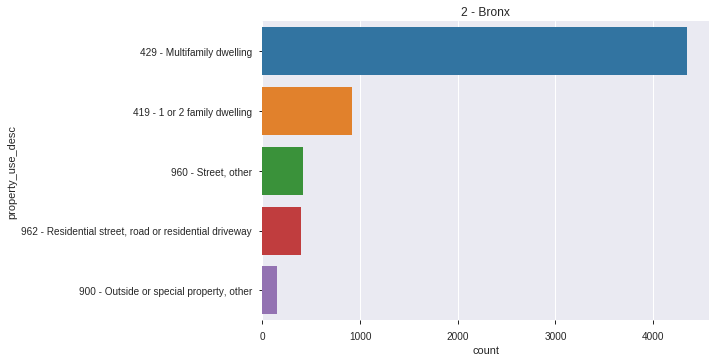

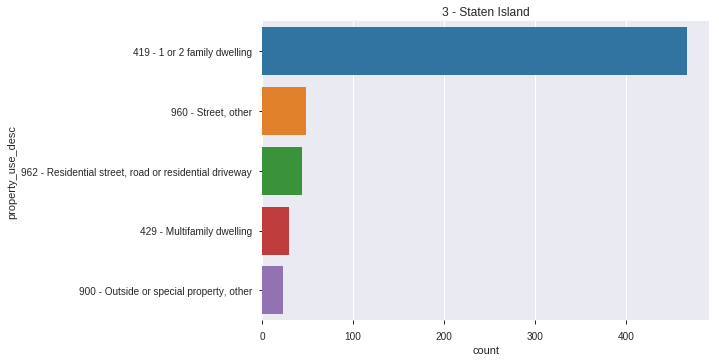

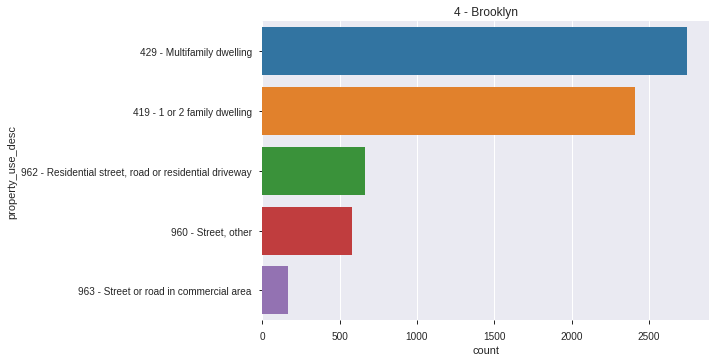

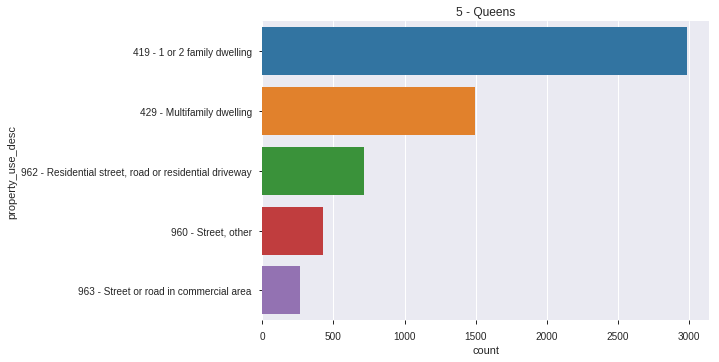

In [278]:
groupByBurough_dwelling(final_df)

## References: 

[1] @ELECTRONIC{firedata,
  author = {Fire Department of New York City (FDNY)},
  year = {2019},
  title = {Incidents Responded to by Fire Companies},
  language = {English},
  howpublished = {\url=https://data.cityofnewyork.us/Public-Safety/Incidents-Responded-to-by-Fire-Companies/tm6d-hbzd},
  owner = {NYC Open Data},
  timestamp = {2019.03.21}
}

[2] @ELECTRONIC{fireboxdata,
  author = {www.poi-factory.com)},
  year = {2008},
  title = {FDNY Firebox Locator Data},
  language = {English},
  howpublished = {\url=http://www.poi-factory.com/node/11074},
  owner = {POI Factory},
  timestamp = {2008.02.26}
}

[3] @ELECTRONIC{firehousedata,
  author = {Fire Department of New York City (FDNY))},
  year = {2018},
  title = {FDNY Firehouse Listing},
  language = {English},
  howpublished = {\url=https://data.cityofnewyork.us/Public-Safety/FDNY-Firehouse-Listing/hc8x-tcnd},
  owner = {NYC Open Data},
  timestamp = {2018.09.10}
}

[4] @ELECTRONIC{firecodelist,
  author = {FDNYnewyork.com},
  year = {2018},
  title = {FDNY Fire Alarm Code Listing and Dispatch Policy},
  language = {English},
  howpublished = {\url=http://www.fdnewyork.com/aa.asp},
  owner = {FDNYnewyork.com},
  timestamp = {2019.09.12}